We first import the necessary packages and load and clean the data sets that we will be using

In [1]:
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator as LNDI

In [61]:
volsurf_df = pd.read_csv("C:\\Users\\Usuario\\Documents\\MSc_Maths_Finance\\Topics_in_Quantitative_Finance\\coursework\\Topics-in-Quant-Finance\\implied vol with delta\\implied vol with delta.csv")
zero_curve = pd.read_csv("C:\\Users\\Usuario\\Documents\\MSc_Maths_Finance\\Topics_in_Quantitative_Finance\\coursework\\Topics-in-Quant-Finance\\implied vol with delta\\Zero Coupon Curve.csv")

In [62]:
#options with less than 10 days to expiry have no implied volatility calculated
volsurf_df = volsurf_df[volsurf_df['days'] != 10] #shouldnt then this be <= 10 or use dropna
volsurf_df = volsurf_df.drop(columns=['index_flag','secid'])

#scale delta to be between 0 and 1
volsurf_df['delta'] = volsurf_df['delta']/100

#interest measured in percentage or basis points?
zero_curve['rate'] = zero_curve['rate']/100

The for some options with ten days to maturity there is not implied vol values, so we need to clean using .dropna

In [63]:
volsurf_df

,date,days,delta,impl_volatility,cp_flag,ticker
17,2000-01-03,30,0.10,0.172792,C,SPX
18,2000-01-03,30,0.15,0.175870,C,SPX
19,2000-01-03,30,0.20,0.179385,C,SPX
20,2000-01-03,30,0.25,0.183127,C,SPX
21,2000-01-03,30,0.30,0.187402,C,SPX
...,...,...,...,...,...,...
847003,2021-12-31,365,0.70,0.245869,C,SPX
847004,2021-12-31,365,0.75,0.263068,C,SPX
847005,2021-12-31,365,0.80,0.283304,C,SPX
847006,2021-12-31,365,0.85,0.307582,C,SPX


In [64]:
volsurf_df[pd.isnull(volsurf_df['impl_volatility'])].head(20)

,date,days,delta,impl_volatility,cp_flag,ticker


In [ ]:
# Using DataFrame.dropna() method drop all rows that have NAN/none.
#volsurf_df = volsurf_df.dropna()
#volsurf_df.head(20)

We work in particular with the date 2021-12-31 trying to replicate the results in the paper.

In [65]:
impl_vol_sample = volsurf_df[volsurf_df['date']=='2021-12-31']

In [66]:
impl_vol_sample

,date,days,delta,impl_volatility,cp_flag,ticker
846872,2021-12-31,30,0.10,0.106347,C,SPX
846873,2021-12-31,30,0.15,0.106598,C,SPX
846874,2021-12-31,30,0.20,0.108139,C,SPX
846875,2021-12-31,30,0.25,0.110721,C,SPX
846876,2021-12-31,30,0.30,0.114071,C,SPX
...,...,...,...,...,...,...
847003,2021-12-31,365,0.70,0.245869,C,SPX
847004,2021-12-31,365,0.75,0.263068,C,SPX
847005,2021-12-31,365,0.80,0.283304,C,SPX
847006,2021-12-31,365,0.85,0.307582,C,SPX


For this particular date we create a grid with time to maturities($\tau$) and strike ($K$).

In [67]:
zero_curve_sample = zero_curve[zero_curve['date'] == '2021-12-31']
zero_curve_sample = zero_curve_sample[zero_curve_sample['days'].isin([30,60,91,122,152,182,273,365])]

In [68]:
impl_vol_sample = pd.merge(impl_vol_sample,zero_curve_sample[['days','rate']], how='left', left_on='days', right_on='days')

In [69]:
impl_vol_sample.head()

,date,days,delta,impl_volatility,cp_flag,ticker,rate
0,2021-12-31,30,0.10,0.106347,C,SPX,0.005311
1,2021-12-31,30,0.15,0.106598,C,SPX,0.005311
2,2021-12-31,30,0.20,0.108139,C,SPX,0.005311
3,2021-12-31,30,0.25,0.110721,C,SPX,0.005311
4,2021-12-31,30,0.30,0.114071,C,SPX,0.005311


In [81]:
#back out moneyness from delta
def inverse_delta(delta,tao,r,sigma):
    '''
    Calculate the moneyness of the option given: 
    - delta the BS delta, 
    - tao   time to expiry, 
    - sigma implied vol, 
    - r     interest rate.
    '''
    d1 = ndtri(delta)
    expr = d1 * sigma * np.sqrt(tao) - tao * (r + sigma**2 / 2)
    m = np.exp(-expr)
    return m

impl_vol_sample['moneyness']=impl_vol_sample.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

In [82]:
impl_vol_sample.head(10)

,date,days,delta,impl_volatility,cp_flag,ticker,rate,moneyness
16,2021-12-31,30,0.90,0.297709,C,SPX,0.005311,0.900052
15,2021-12-31,30,0.85,0.248360,C,SPX,0.005311,0.931625
14,2021-12-31,30,0.80,0.211811,C,SPX,0.005311,0.952346
13,2021-12-31,30,0.75,0.187972,C,SPX,0.005311,0.966127
12,2021-12-31,30,0.70,0.172017,C,SPX,0.005311,0.976082
11,2021-12-31,30,0.65,0.159957,C,SPX,0.005311,0.983948
10,2021-12-31,30,0.60,0.150027,C,SPX,0.005311,0.990510
9,2021-12-31,30,0.55,0.141568,C,SPX,0.005311,0.996167
8,2021-12-31,30,0.50,0.134309,C,SPX,0.005311,1.001179
7,2021-12-31,30,0.45,0.128080,C,SPX,0.005311,1.005741


We now create a grid for the volatility surface given moneyness and time to maturity.

In [73]:
#We now create the grid
m_grid=np.linspace(0.6,1.4,11)
t_grid=[30,60,91,122,152,182,273,365]


#Interpolate first in moneyness
impl_vol_sample.sort_values(['days','moneyness'],inplace=True)
interpolated_points=[]
interpolated_df=pd.DataFrame()

for t in t_grid:
    sub_df=impl_vol_sample[impl_vol_sample['days']==t]
    f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
    
    #use structure of sub_df to set up new data frame of interpolated points
    sub_df=sub_df[:11]
    interpolated_points=f(m_grid)
    
    #replace columns for new interpolated grid
    sub_df['moneyness']=m_grid
    sub_df['impl_volatility']=interpolated_points
    
    interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
    interpolated_df.drop(columns=['delta'],inplace=True) #no longer in order
    
    
#interpolation here seems somewhat strange, paper also says to interpolate in time to maturity, but we already have this?



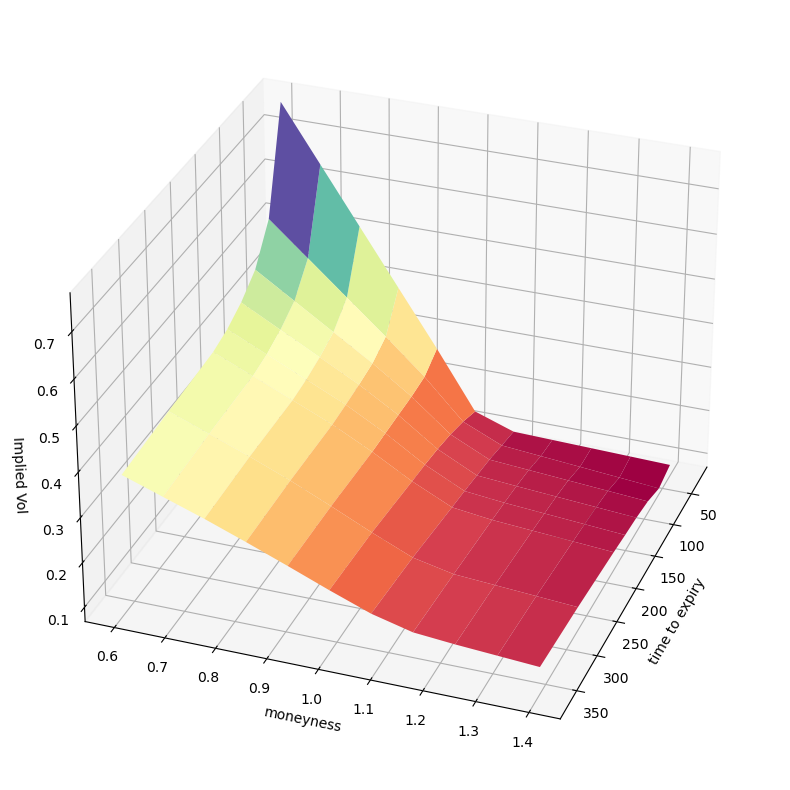

In [74]:
#create surface

tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=20)
plt.show()

In [83]:
def interpolate_impliedvol(moneyness, tau, df):
    """
    Calculate implied volatility by linear interpolation first in moneyness and then time to maturity.
    
    Args:
    - moneyness (float): The moneyness value,
    - tau (float): The time to maturity,
    - df (pandas.DataFrame): The DataFrame containing the moneyness, tau, and impliedvol columns.
    
    Returns:
        float: The interpolated impliedvol value.
    """
    # Sort the DataFrame by moneyness and tau
    df_sorted = df.sort_values(['moneyness', 'tau'])
    
    # Interpolate in moneyness
    moneyness_values = df_sorted['moneyness'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['moneyness']==m, 'impliedvol'].values for m in moneyness_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=moneyness_values).interpolate(method='linear')(moneyness)
    
    # Interpolate in tau
    tau_values = df_sorted['tau'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['tau']==t, 'impliedvol'].values for t in tau_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=tau_values).interpolate(method='linear')(tau)
    
    return impliedvol_interp


In [85]:
#Next is to implement arbitrage penalties
pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility')
interpolated_df

,date,days,impl_volatility,cp_flag,ticker,rate,moneyness
0,2021-12-31,30,0.766708,C,SPX,0.005311,0.60
1,2021-12-31,30,0.641663,C,SPX,0.005311,0.68
2,2021-12-31,30,0.516619,C,SPX,0.005311,0.76
3,2021-12-31,30,0.391574,C,SPX,0.005311,0.84
4,2021-12-31,30,0.266530,C,SPX,0.005311,0.92
...,...,...,...,...,...,...,...
83,2021-12-31,365,0.173222,C,SPX,0.006907,1.08
84,2021-12-31,365,0.150316,C,SPX,0.006907,1.16
85,2021-12-31,365,0.142311,C,SPX,0.006907,1.24
86,2021-12-31,365,0.136121,C,SPX,0.006907,1.32


In [86]:
def c(m,tao,r,sigma):
    #calculate call price
    d1=(-np.log(m)+tao*(r+sigma**2/2))/(sigma*np.sqrt(tao))
    d2=(-np.log(m)+tao*(r-sigma**2/2))/(sigma*np.sqrt(tao))
    return norm.cdf(d1)-m*np.exp(-r*tao)*norm.cdf(d2)

#calendar spread arbitrage penalty
def p1(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    pivot_df=pd.pivot(df,index=['time'],columns=['moneyness'],values='c')
    pivot_df=pivot_df-pivot_df.shift(-1)
    time_diff=np.diff(pivot_df.index.to_numpy())
    
    pivot_df=pivot_df.iloc[:-1]
    #divide by time difference and multiply by time
    
    #in the paper for the sum they have mutliply by tj but not in the matrix version is this a typo?
    if(matrix):
        pivot_df=pivot_df.T/time_diff
        pivot_df=np.maximum(pivot_df,0)
        return pivot_df
    else:
        pivot_df=pivot_df.T/time_diff*pivot_df.index
        pivot_df=np.maximum(pivot_df,0)
    
    #now sum across columns and rows
    p1=pivot_df.sum().sum()
    return p1

In [87]:
#call spread arbitrage penalty
def p2(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    pivot_df=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    pivot_df=pivot_df.iloc[:-1]
    #divide by difference in moneyness
    pivot_df=pivot_df.T/money_diff
    pivot_df=np.maximum(pivot_df,0)
    if(matrix):
        return pivot_df
    else:
        return pivot_df.sum().sum()

In [88]:
#butterfly spread arbitrage penalty
def p3(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    
    #second term
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    df_1=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    df_1=df_1.iloc[:-1]
    df_1=df_1.T/money_diff
    
    #frist term
    df_2=pivot_df-pivot_df.shift(1)
    df_2=df_2.iloc[1:]
    df_2=df_2.T/money_diff
    
    df_3=df_2-df_1
    df_3=df_3.iloc[:,1:-1]
    df_3=np.maximum(df_3,0)
    if(matrix):
        return df_3
    else:
        return df_3.sum().sum()

Skipping part about perturbations, not sure if it's ever used again

### Interpolating Interest Rates

In [89]:
#interpolate interest rates to work with volsurf_df
zero_curve

,date,days,rate
0,2000-01-03,7,0.059296
1,2000-01-03,16,0.059142
2,2000-01-03,44,0.060177
3,2000-01-03,72,0.060907
4,2000-01-03,107,0.061550
...,...,...,...
250023,2021-12-31,182,0.005868
250024,2021-12-31,273,0.006338
250025,2021-12-31,365,0.006907
250026,2021-12-31,547,0.008269


In [90]:
day_list=np.array([30,60,91,122,152,182,273,365])

In [91]:
#make a new dataframe with these days
dates=zero_curve['date'].unique()

rep_days=np.tile(day_list,len(dates))
rep_dates=np.repeat(dates,len(day_list))
df_to_merge=pd.DataFrame(np.vstack((rep_dates,rep_days)).T,columns=['date','days'])

#now merge dfs to make na's so we can interpolate
merged_df=pd.merge(zero_curve, df_to_merge, how='outer', on=['date','days'])
merged_df=merged_df.sort_values(['date','days'])
merged_df['days']=merged_df['days'].astype(int)
merged_df=merged_df.set_index(['days'])

for date in dates:
    merged_df[merged_df['date']==date]=merged_df[merged_df['date']==date].interpolate(method='spline',order=3)

c:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [688]:
interpolated_rates=merged_df

In [689]:
interpolated_rates=interpolated_rates.reset_index()

In [690]:
impl_vol_df

,date,days,delta,impl_volatility,cp_flag,ticker,rate
0,2000-01-03,30,0.10,0.172792,C,SPX,0.060394
1,2000-01-03,30,0.15,0.175870,C,SPX,0.060394
2,2000-01-03,30,0.20,0.179385,C,SPX,0.060394
3,2000-01-03,30,0.25,0.183127,C,SPX,0.060394
4,2000-01-03,30,0.30,0.187402,C,SPX,0.060394
...,...,...,...,...,...,...,...
752891,2021-12-31,365,0.70,0.245869,C,SPX,0.006907
752892,2021-12-31,365,0.75,0.263068,C,SPX,0.006907
752893,2021-12-31,365,0.80,0.283304,C,SPX,0.006907
752894,2021-12-31,365,0.85,0.307582,C,SPX,0.006907


In [694]:
#add rates to volsurface dataframe
impl_vol_df=pd.merge(volsurf_df,interpolated_rates,how='left',left_on=['date','days'],right_on=['date','days'])

#some dates were not included in the zero_curve file, interpolate for these
for days in impl_vol_df['days'].unique():
    impl_vol_df[impl_vol_df['days']==days]=impl_vol_df[impl_vol_df['days']==days].interpolate(method='spline',order=3)

#calculate moneyness
impl_vol_df['moneyness']=impl_vol_df.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

## Work in Progress

In [696]:
impl_vol_df['c']=impl_vol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

Need to create a fixed grid for m, so that we can create a proper surface when calculating the arbitrage penalties

In [801]:
def interpolate_moneyness(df):
    '''
    Takes as argument a dataframe with:
    days,moneyness,inpl_volatility columns, delta and c
    
    Returns:
    Dataframe with implied volatility values linearly interpolated to fit the gird of
    moneyness values
    '''
    m_grid=np.linspace(0.6,1.4,10)
    t_grid=df['days'].unique()
    
    #interpolate in moneyness
    df=df.sort_values(['days','moneyness'])
    interpolated_points=[]
    interpolated_df=pd.DataFrame()
    
    for t in t_grid:
        sub_df=df[df['days']==t]
        #interpolation function
        f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
        #use structure of sub_df to set up new data frame of interpolated points
        sub_df=sub_df[:10]
        interpolated_points=f(m_grid)
        #replace columns for new interpolated grid
        sub_df['moneyness']=m_grid
        sub_df['impl_volatility']=interpolated_points

        interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
        interpolated_df.drop(columns=['delta','c'],inplace=True)
        #delta and c are no longer accurate
    return interpolated_df

In [802]:
interp_implvol_df=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df=pd.concat([interp_implvol_df,interpolate_moneyness(temp_df)])

KeyboardInterrupt: 

In [ ]:
interp_implvol_df.reset_index(inplace=True)
#now calculate call values
interp_implvol_df['c']=interp_implvol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [795]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)

KeyError: 'date'

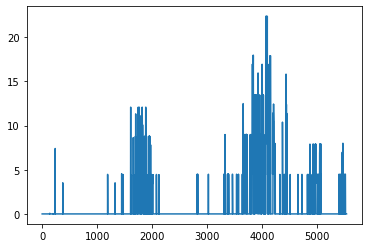

In [796]:
plt.plot(p3_vals.values)

In [790]:
test_sample=interp_implvol_df[interp_implvol_df['date']=='2020-03-13']

In [791]:
p1(test_sample,matrix=True)

C:\Users\david\AppData\Local\Temp\ipykernel_10200\1948588221.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365


time,0.082192,0.164384,0.249315,0.334247,0.416438,0.498630,0.747945
moneyness,,,,,,,
0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.688889,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.866667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.955556,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.044444,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.311111,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##In the following cells we develop the reweighting approach for Montecarlo simulations, giving lower weights to the penalised paths. The bigger the static arbitrage present, the bigger penalization.

A path is a realization of the evolution of the volatility surface:
$$(S_t(w_i), \sigma_t(m,\tau,w_i);t\in \{0, \dots  t_{max}\})$$
under the measure $\mathbb{P}_0$ (physical dynamics). 

Once we have a simulation of $N$ paths we add a weight to each path as following:
$$w_i(\beta):= \frac{exp(-\beta \phi(w_i))}{\sum_{j=1}^N exp(-\beta \phi(w_j))}$$

The paths parameters of the following function is expected to be a dataframe whose columns represent a path simulation

In [140]:
def call(m, tau, sigma, r):
    '''
    Function that retuns the price of a European Call given:
    - m     moneyness
    - tau   time to maturity
    - sigma volatility
    - r     interest rate
    '''
    d1 = (np.log(m)+ tau * (r + sigma**2 / 2)) / (sigma * np.sqrt(tau))
    d2 = (np.log(m)+ tau * (r - sigma**2 / 2)) / (sigma * np.sqrt(tau))
    return norm.cdf(d1) - m * np.exp(-r * tau) * norm.cdf(d2)

In [ ]:
def MCWEIGHTING(paths, beta, T):
    """
    This functions reweights the simulations giving a greater weight 
    to those with less or no arbitrage

    Parameters:
    - paths simulated paths of under choosen dynamics (insert as a numpy 3d array)
    - beta  arbitrage tolerance parameter, big beta means small arbitrage tolerance
    - T     time to maturity
    Return:
    - The weighted average of the simulated paths to reduce the arbitrage.
    """
    
    m,n,r = paths.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),paths.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr)
    out_df.columns = ['omega', 'time', 'S_t', 'Vol_t']
    out_df['moneyness'] = K / out_df['S_t']
    out_df['tau'] = np.abs(T - out_df['time'])
    
    out_df['p1'] =  out_df['tau'] * (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'].shift(1), out_df['Vol_t'], r)) /(out_df['tau'] - out_df['tau'].shift(1))
    out_df['p2'] =  (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['tau'])
    out_df['p3'] = (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'].shift(-1), out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'] - out_df['tau'].shift(-1)) - (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['tau'])
    out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3']

    # Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
    grouped_df = out_df.groupby('omega')['totalpen'].sum()

    # Sum the totalpenalization column and assign the result to a new DataFrame:
    sumpen = grouped_df.sum()

    #We calculate the weights:
    weights = grouped_df/sumpen

    #remains to do the final sum.


    

In [ ]:
N = 10
M = 5
r = 0.05
K = 100
T = 1
a = np.abs(np.random.normal(0, 10, (M, M, 3)))

m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)
out_df.columns = ['omega', 'time', 'S_t', 'Vol_t']
out_df['moneyness'] = K / out_df['S_t']
out_df['tau'] = np.abs(T - out_df['time'])
out_df

In [167]:
out_df['p1'] =  out_df['tau'] * (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'].shift(1), out_df['Vol_t'], r)) /(out_df['tau'] - out_df['tau'].shift(1))
out_df['p2'] =  (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['tau'])
out_df['p3'] = (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'].shift(-1), out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'] - out_df['tau'].shift(-1)) - (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['tau'])
out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3'] 

In [ ]:
out_df

In [172]:
# Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = out_df.groupby('omega')['totalpen'].sum()

# Print the resulting DataFrame
print(grouped_df)

# Sum the totalpenalization column and assign the result to a new DataFrame
sumpen = grouped_df.sum()

# Print the resulting DataFrame
print(sumpen)

#We calculate the weights:
weights = grouped_df/sumpen

print(weights)

omega
0.0    0.183096
1.0    0.001582
2.0    1.782344
3.0    0.653006
4.0    2.378302
Name: totalpen, dtype: float64
4.998330653318204
omega
0.0    0.036632
1.0    0.000317
2.0    0.356588
3.0    0.130645
4.0    0.475819
Name: totalpen, dtype: float64
